In [0]:
#imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
import datetime
from os import listdir
from sklearn.metrics import mean_squared_error

def download_url(url, save_path):  
  import requests
  r = requests.get(url, stream=True)
  with open(save_path, 'wb') as fd:
      for chunk in r.iter_content(chunk_size=128):
          fd.write(chunk)

> Downloading dataset

In [2]:
if ('time_series_covid19_confirmed_global.csv') in listdir():
  pass
else:
  #same time_series file as that of kaggle
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
  download_url(url,'/content/time_series_covid19_confirmed_global.csv')

df = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirm = df.iloc[:,4:131]

keys = confirm.keys()
print(keys)

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '5/18/20', '5/19/20', '5/20/20', '5/21/20', '5/22/20', '5/23/20',
       '5/24/20', '5/25/20', '5/26/20', '5/27/20'],
      dtype='object', length=127)


> Adding all confirmed cases country wise

In [0]:
uniq_countries = df['Country/Region'].unique()
countries = list()
for c in uniq_countries:
  country = confirm.loc[df['Country/Region'] == c]
  s = country.sum(axis = 0) 
  countries.append([c,s.values])

> Removing initial zeros, finding deviation from Pakistan, plotting

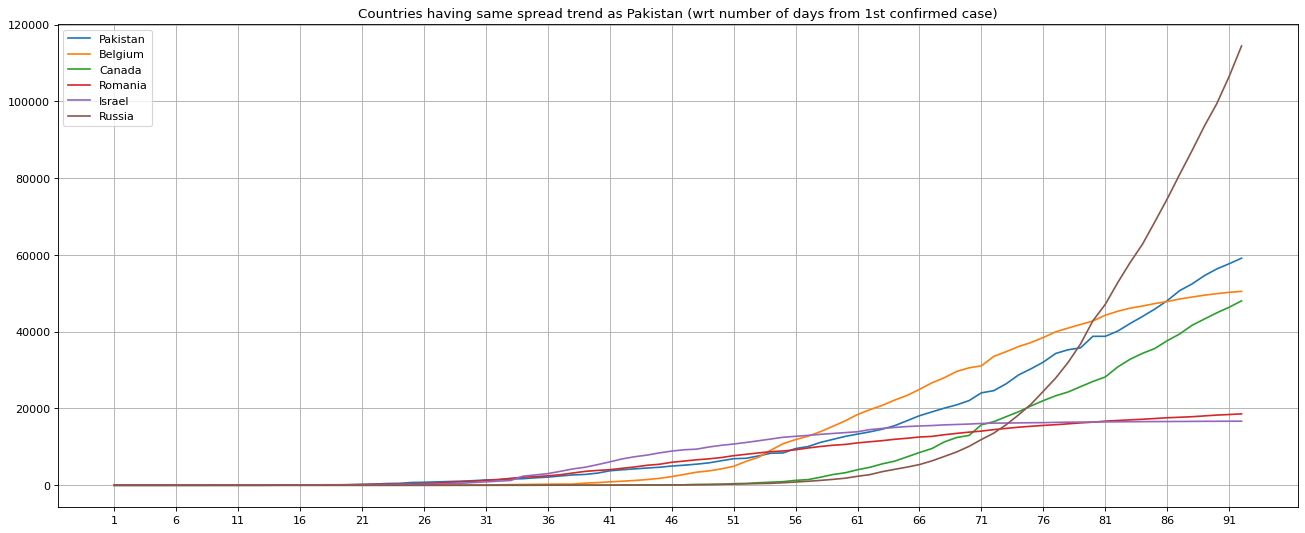

In [4]:
#Removing initial zeros
def separate(countries):
  c = list()
  for i in countries:
    temp = np.trim_zeros(i[1])
    zeros = len(i[1])-len(temp)
    if i[0]=='Pakistan':
      pak = [i[0],temp,zeros]
    c.append([i[0],temp,zeros])
  return pak, c

#Finding deviation from pakistan's data
def finddeviation(pak, restcountries):
  threshold = 0
  limit = len(pak[1]) - threshold
  dev = list()
  for i in restcountries:
    l = len(i[1])
    if l>=limit:
      subsum = sum(np.abs(i[1][:limit]-pak[1][:limit]))
      dev.append([i[0],subsum,i[2]])    
      
  return np.array(sorted(dev,key=lambda l:l[1]))

#plotting trend
def plottrend(allcountries, topfive):
  allcountries = np.array(allcountries)
  plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
  for i in topfive:
    index = np.where(allcountries[:,0] == i)
    rows = allcountries[index][0][1]
    plt.plot(np.arange(1,92+1),rows[:92],label=i)
  plt.grid(True)
  plt.xticks(np.arange(1,92+1,5))
  #plt.yscale('log')
  plt.legend()
  plt.title('Countries having same spread trend as Pakistan (wrt number of days from 1st confirmed case)')
  plt.show()

pak, allcountries = separate(countries)    # separating Pakistan and removing 0s
dev = finddeviation(pak, allcountries)     # countries with least deviation from Pakistan (in ascending order)
topfive = dev[:6][:,[0,2]]                 # top 5 countries with save trend as Pakistan (5+1)
plottrend(allcountries, topfive[:,0])

> Converting to new cases per day

In [0]:
#Converting to new cases per day
def getcasesperday(allcountries, topfive):
  alldif = list()
  allcountries = np.array(allcountries)
  for i in topfive:
    dif = list()
    index = np.where(allcountries[:,0] == i[0])
    cases = allcountries[index][0][1]
    cases = np.insert(cases, 0, 0)
    for j in range(1,len(cases)):
      dif.append(cases[j]-cases[j-1])
    alldif.append([i[0],np.array(dif),i[1]])
  return alldif

alldif = getcasesperday(allcountries, topfive)

> Normalizing

In [0]:
# Normalizing training data using MinMaxScaler
sc = list()
train = list()
for i in alldif:
  s = MinMaxScaler()
  train.append(s.fit_transform(i[1].reshape(-1,1)))
  sc.append(s)

> Getting sequence

In [0]:
#Get training and prediciting sequence arrays
def getdataset(seq, vals):
  X, y = list(), list()
  pred_X, pred_y = list(), list()
  for j in range(seq,len(vals)):
      y.append(vals[j])
      X.append(vals[j-seq:j])
      if j>len(vals)-19:
        pred_X.append(vals[j-seq:j])
        pred_y.append(vals[j])

  #Converting to tensor and reshaping
  X = Variable(torch.Tensor(np.array(X)))
  y = Variable(torch.Tensor(np.array(y)).view(-1,1))
  pred_X = torch.Tensor(np.array(pred_X))
  pred_y = np.array(pred_y).reshape(-1,1)
  return X, y, pred_X, pred_y

> RNN Model

In [0]:
#Using RNN to predict
class RNNPredictor(nn.Module):
    def __init__(self, input_dimension, hidden_dimension, num_layers, output_dimension):
        super(RNNPredictor, self).__init__()

        self.hidden_dimension = hidden_dimension
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_dimension, hidden_dimension, num_layers, batch_first=True, nonlinearity='relu')
        self.final = nn.Linear(hidden_dimension, output_dimension)

    def forward(self, x):
        hidden = torch.zeros(self.num_layers, x.size(0), self.hidden_dimension) # initializing hidden layer with zeros

        output, hidden = self.rnn(x, hidden)
        
        output = self.final(output[:, -1, :]) #getting last output row only (3D to 2D)
        
        return output

> Training model

In [0]:
#Parameters for model 
num_epochs = 2001
learning_rate = 0.01

input_dimension = 1
hidden_dimension = 300
num_layers = 2
output_dimension = 1

seq = 10

criterion = torch.nn.MSELoss()    # mean squared error

> Finding predictions

In [0]:
#Find predictions
def findpredictions(seq, x):
  pred_rest = [x]
  y_pred = list()

  for i in range(32):
    tor = torch.Tensor(pred_rest[i]).view(1,seq,1)
    pred = model(tor).data.numpy()
    shift_left = np.roll(pred_rest[i],-1) #shifts left
    shift_left[-1] = pred                 #replace last value with prediction
    pred_rest.append(shift_left)
    y_pred.append(pred[0])

  return y_pred

In [90]:
# All in one
countries_predicted = list()

for i in range(len(train)): 
  X, y, pred_X, pred_y = getdataset(seq, train[i])

  #Creating Model
  model = RNNPredictor(input_dimension, hidden_dimension, num_layers, output_dimension)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Training Model
  model.train()
  for epoch in range(num_epochs):
      optimizer.zero_grad()
      outputs = model(X)      
      loss = criterion(outputs, y)    
      loss.backward()     
      optimizer.step()
      if epoch % 500 == 0:
        valout = model(pred_X).data.numpy()
        valloss = mean_squared_error(valout, pred_y)    
        print("%s: \tEpoch: %d\tLoss: %f\tVal loss: %f" % (topfive[i][0], epoch, loss.item(),valloss.item()))

  #Prediction from 10th May to 26th May
  model.eval()
  pred = model(pred_X).data.numpy()
  y_pred1 = np.round(sc[i].inverse_transform(pred))    #rounding predictions
  org_y = sc[i].inverse_transform(pred_y)

  #Prediction from 27th May to 27th June
  temp_y = findpredictions(seq, pred_X[-1])
  y_pred2 = np.round(sc[0].inverse_transform(temp_y))   #rounding predictions

  #Combined Predictions [country, predictions]
  countries_predicted.append([topfive[i],np.concatenate((y_pred1[:-1],y_pred2),axis=0)])
  print()

Pakistan: 	Epoch: 0	Loss: 0.124913	Val loss: 127.919331
Pakistan: 	Epoch: 500	Loss: 0.001041	Val loss: 0.000002
Pakistan: 	Epoch: 1000	Loss: 0.000500	Val loss: 0.000008
Pakistan: 	Epoch: 1500	Loss: 0.000082	Val loss: 0.000003
Pakistan: 	Epoch: 2000	Loss: 0.000026	Val loss: 0.000000

Belgium: 	Epoch: 0	Loss: 0.116619	Val loss: 65.578630
Belgium: 	Epoch: 500	Loss: 0.000437	Val loss: 0.000175
Belgium: 	Epoch: 1000	Loss: 0.000078	Val loss: 0.000052
Belgium: 	Epoch: 1500	Loss: 0.000081	Val loss: 0.000022
Belgium: 	Epoch: 2000	Loss: 0.000037	Val loss: 0.000007

Canada: 	Epoch: 0	Loss: 0.210102	Val loss: 8.491986
Canada: 	Epoch: 500	Loss: 0.001161	Val loss: 0.001412
Canada: 	Epoch: 1000	Loss: 0.000023	Val loss: 0.000024
Canada: 	Epoch: 1500	Loss: 0.000023	Val loss: 0.000010
Canada: 	Epoch: 2000	Loss: 0.000024	Val loss: 0.000031

Romania: 	Epoch: 0	Loss: 0.249348	Val loss: 16.343947
Romania: 	Epoch: 500	Loss: 0.014128	Val loss: 0.012651
Romania: 	Epoch: 1000	Loss: 0.000058	Val loss: 0.000054
R

> Dates (for x-axis)

In [0]:
#Getting dates array (01/22 - 06/30)
dates = ["01/22"]
for i in range(160):
  start = datetime.datetime.strptime(dates[-1]+'/20', "%m/%d/%y")
  dt = start + datetime.timedelta(days=1)
  dates.append(dt.strftime("%x")[:-3])

> Plotting predictions

In [0]:
def compare(cnts, y, dates):
  plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
  plt.plot(dates,[0]*161,alpha=0,color='white')
  for dif in cnts:
    zeros = int(dif[2])
    plt.plot(dates[zeros:zeros+len(dif[1])], dif[1], label=dif[0])
  plt.plot(dates[109:109+len(y[1])], y[1], label=f'Prediction({y[0][0]})', linestyle='dashed', color='red')
  plt.grid(True)
  plt.xticks(np.arange(0,len(dates),5))
  plt.legend(loc=2)
  plt.title(f'Prediction (using {y[0][0]}\'s data)', fontsize=15)
  plt.xlabel('Dates', fontsize=15)
  plt.ylabel('New Cases', fontsize=15)
  plt.show()

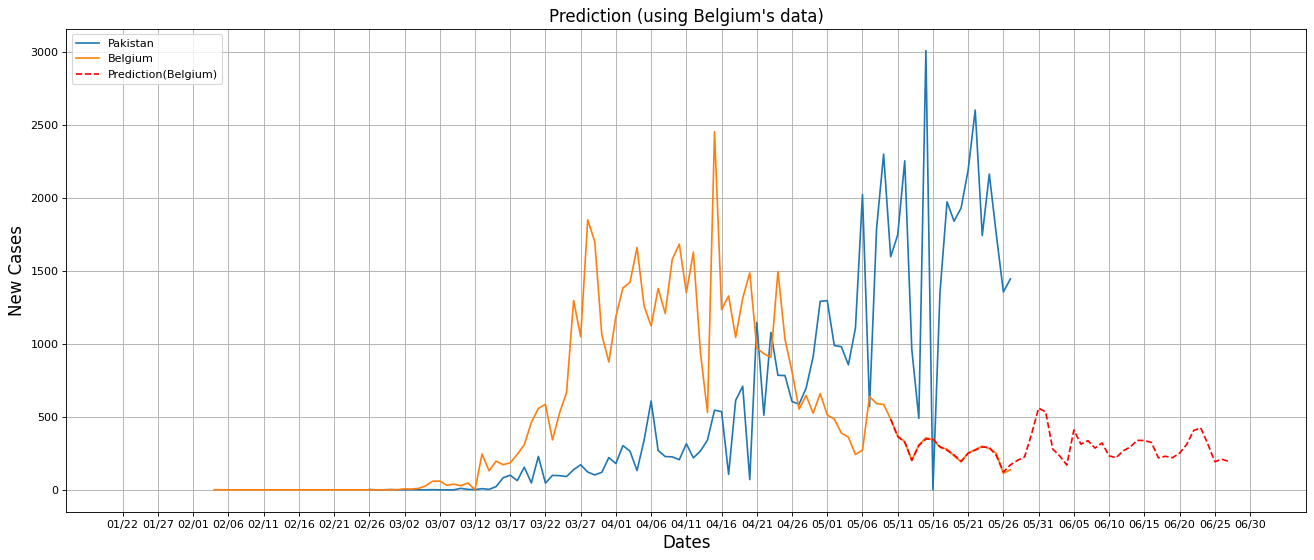

In [93]:
compare([alldif[0],alldif[1]], countries_predicted[1], dates)

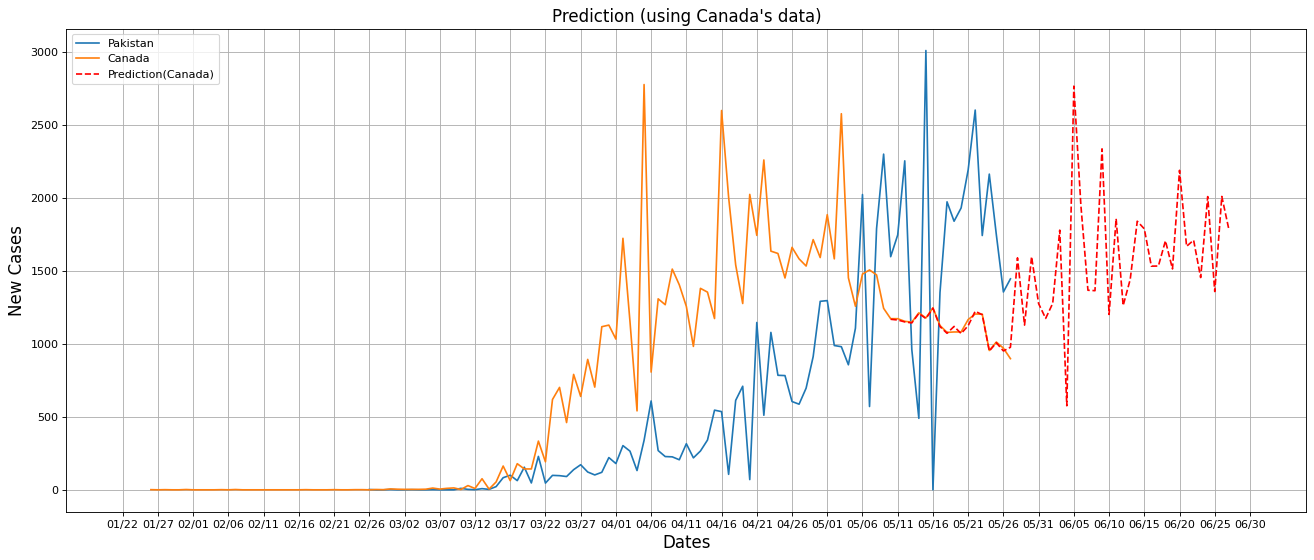

In [94]:
compare([alldif[0],alldif[2]], countries_predicted[2], dates)

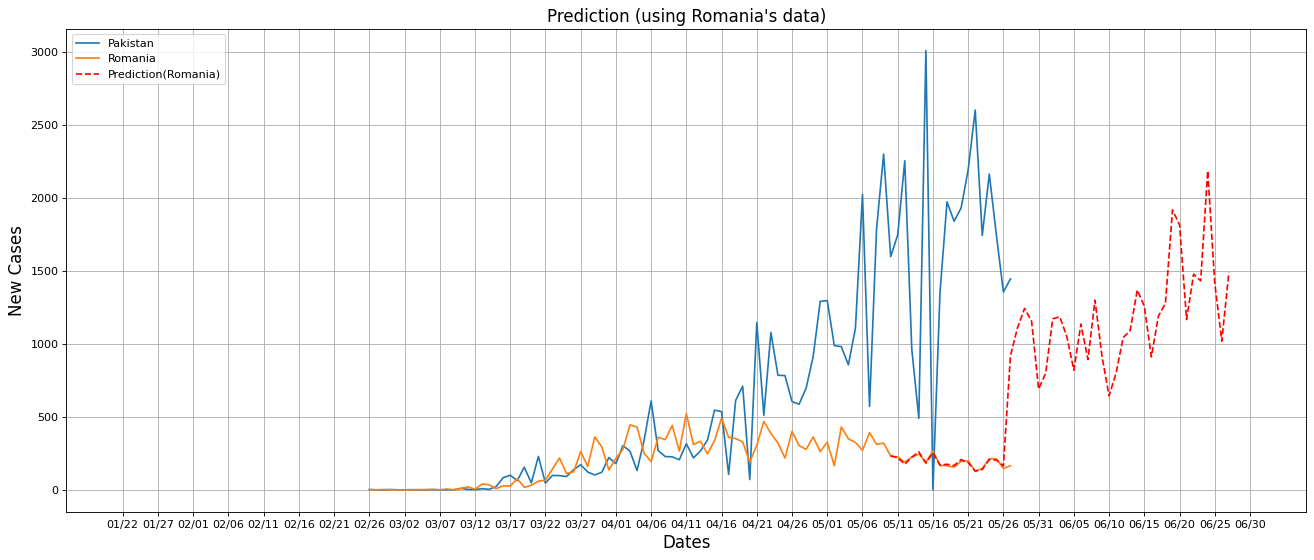

In [95]:
compare([alldif[0],alldif[3]], countries_predicted[3], dates)

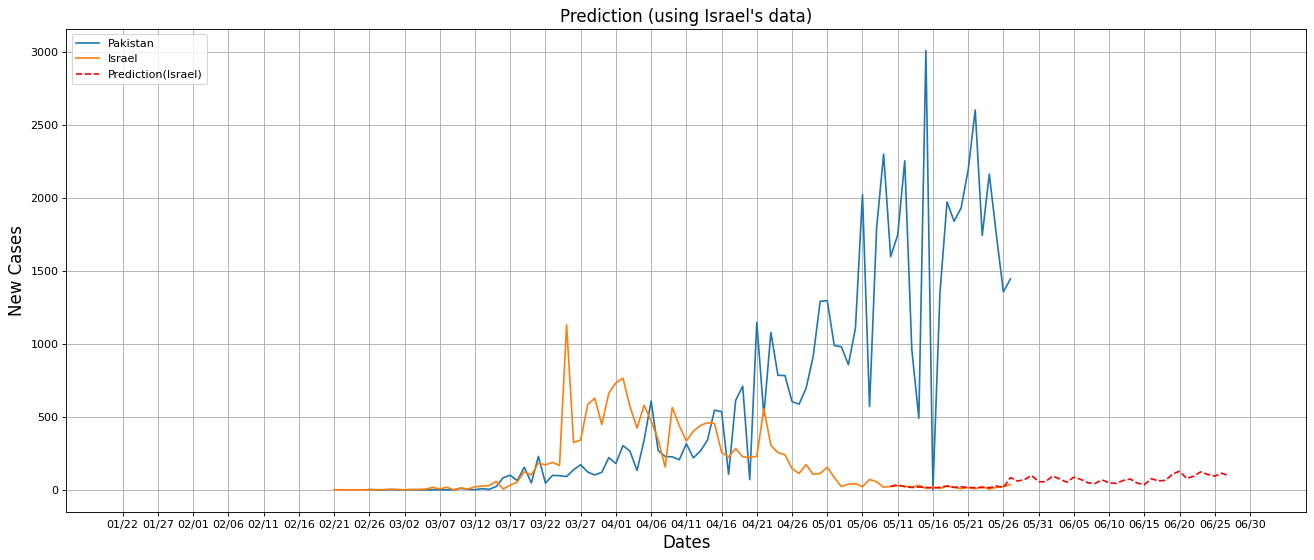

In [96]:
compare([alldif[0],alldif[4]], countries_predicted[4], dates)

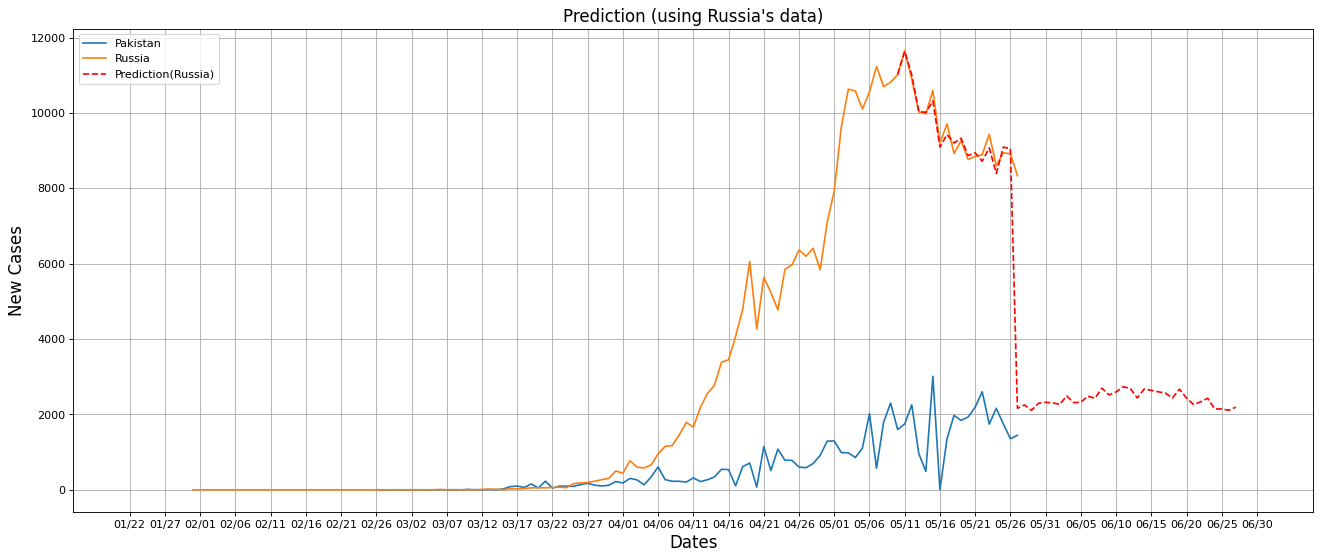

In [97]:
compare([alldif[0],alldif[5]], countries_predicted[5], dates)

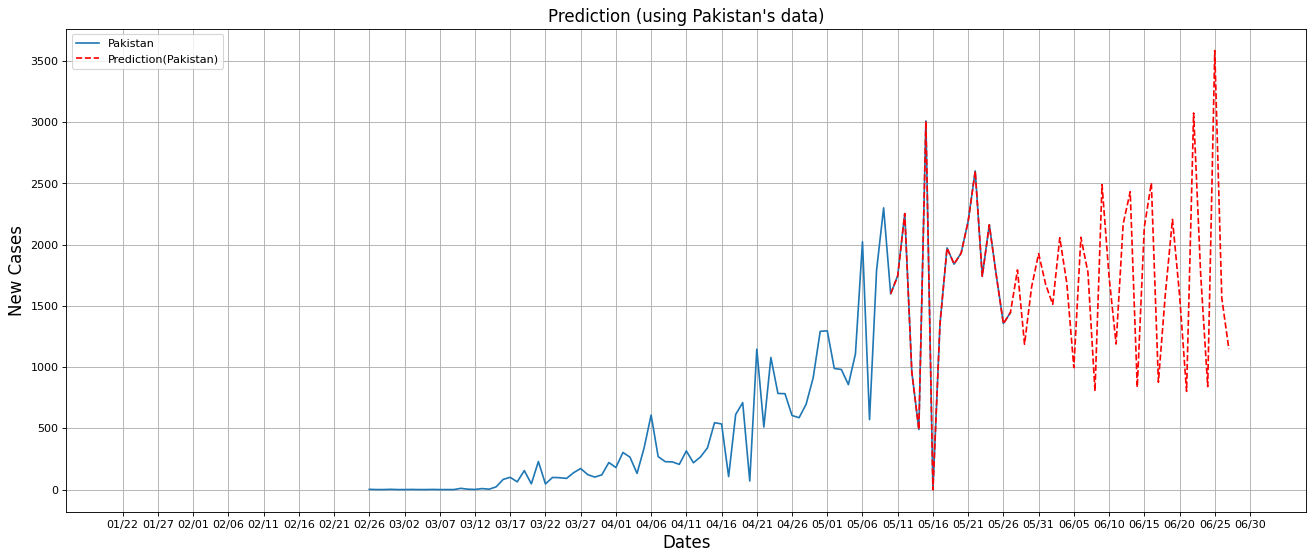

In [98]:
compare([alldif[0]], countries_predicted[0], dates)

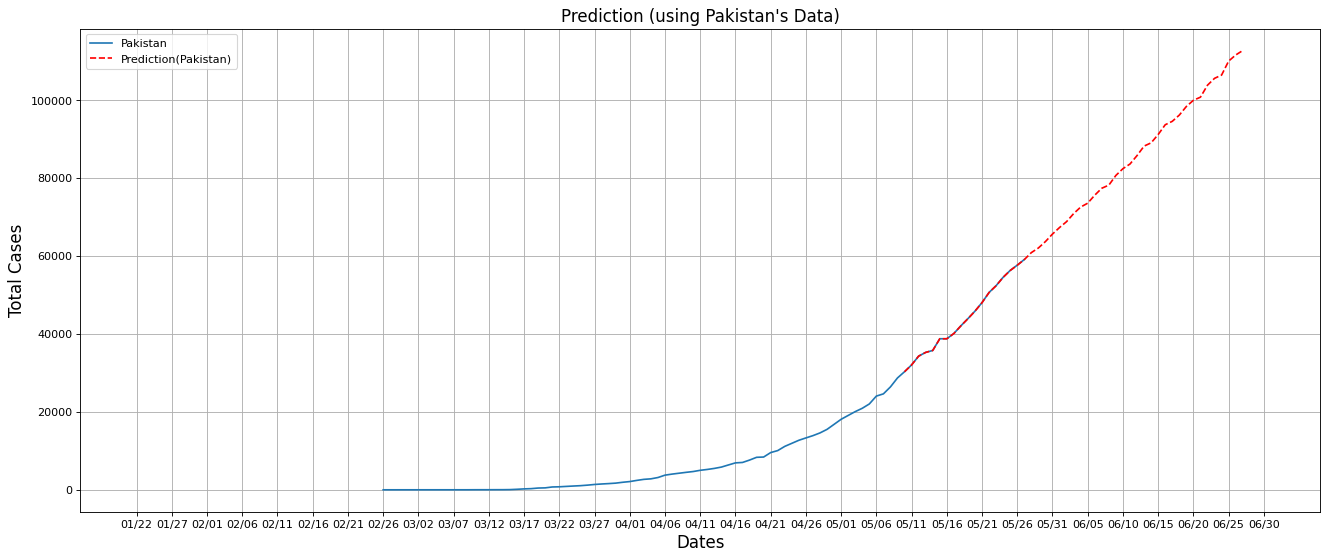

In [99]:
#Cumulative Sum Plot
sums = np.cumsum(alldif[0][1])
cases = countries_predicted[0][1]
cases = np.insert(cases, 0, sums[73]) #05/09 value
p = np.cumsum(cases)[1:]
zeros = int(alldif[0][2])

plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dates,[0]*161,alpha=0,color='white')
plt.plot(dates[zeros:zeros+len(sums)], sums, label='Pakistan')
plt.plot(dates[109:109+len(p)], p, label='Prediction(Pakistan)', linestyle='dashed', color='red')
plt.grid(True)
plt.xticks(np.arange(0,len(dates),5))
plt.legend(loc=2)
plt.title('Prediction (using Pakistan\'s Data)', fontsize=15)
plt.xlabel('Dates', fontsize=15)
plt.ylabel('Total Cases', fontsize=15)
plt.show()